In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.filters import meijering, sato, frangi, hessian
from skimage.measure import label, regionprops
from skimage import exposure
from sklearn import decomposition
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks
import helpers

In [2]:
filename = 'benoitdata/F20_10_b/6um_jamtveit_att_pag-1.99_3.12_00030.tif'
im = Image.open(filename)
imarr = np.array(im)

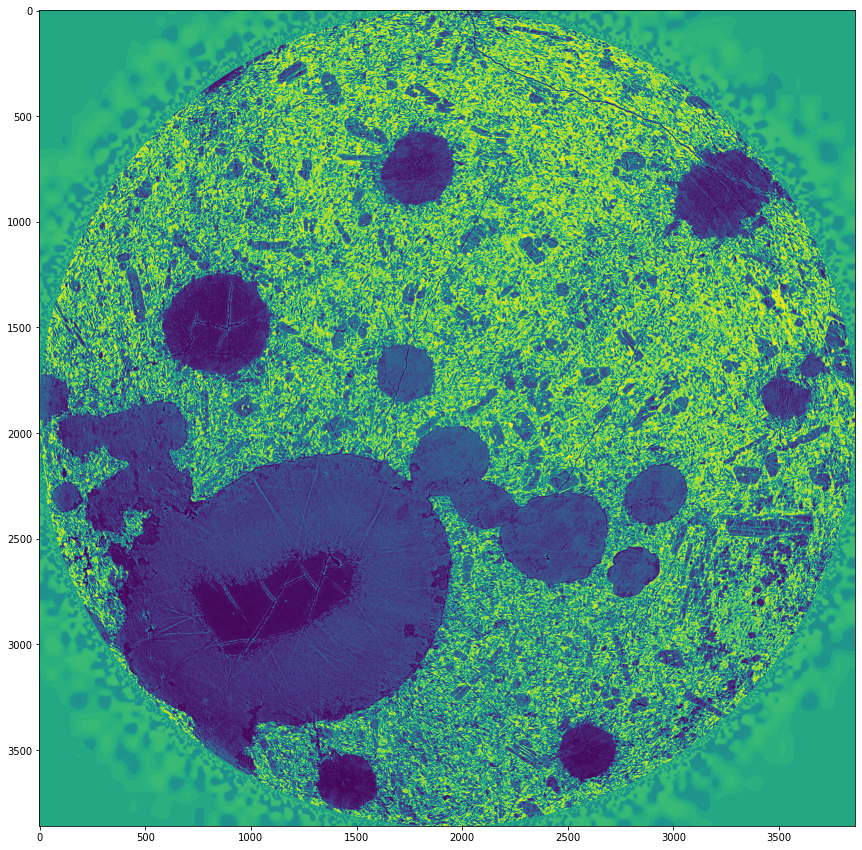

In [3]:
imarr_hist = exposure.equalize_hist(imarr)

fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(imarr_hist)


In [4]:
# imarr_maskradius = helpers.remove_data_based_on_radius(imarr, mask_value=np.nan)
imarr_maskradius = helpers.remove_data_based_on_radius(imarr_hist, mask_value=np.nan)

In [5]:
gauss_sigmas = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
blurs = [gaussian_filter(imarr_maskradius, sigma=sigma) for sigma in gauss_sigmas]

In [38]:
# def get_peaks_means_stds(img, height, width):
def get_peaks_means_stds(img, height, width, distance):
    h, e = np.histogram(img[~np.isnan(img)].flatten(), bins=1000)
    peaks, other = find_peaks(h, height=height, width=width, distance=distance)
    means = e[peaks]
    stds = np.std(img[~np.isnan(img)].flatten())/3
    
    return dict(zip(('hist', 'edges', 'peaks', 'means', 'stds'), (h, e, peaks, means, stds)))

def label_by_peaks(img, peaks):
    zeros = np.zeros_like(img)
    std = peaks['stds']
    for n, m in enumerate(peaks['means']):
        plower = m - std
        pupper = m + std
        x, y = np.where(np.logical_and(img>plower, img<pupper))
        zeros[x, y] = n + 1
        
    return helpers.remove_data_based_on_radius(zeros, mask_value=np.nan)

In [39]:
# peaks_etc = [get_peaks_means_stds(b, height=1e3, width=4) for b in blurs]
peaks_etc = [get_peaks_means_stds(b, height=1e3, width=4, distance=0.1) for b in blurs]

ValueError: `distance` must be greater or equal to 1

In [40]:
peak_labled = [label_by_peaks(blurs[s-1], peaks_etc[s-1]) for s in gauss_sigmas]

In [9]:
# import matplotlib as mpl
# cmap = plt.cm.jet  # define the colormap
# cmaplist = [cmap(i) for i in range(cmap.N)]
# cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

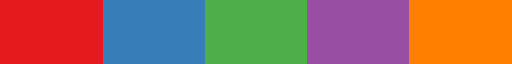

In [10]:
# n = 5
# mpl.colors.LinearSegmentedColormap.from_list('dfg', plt.cm.Set1(range(0,n)), n)

[0 1 2 3 4 5 6 7 8 9]
0.0    1867222
2.0     801848
3.0     192184
4.0    2958954
5.0     594582
6.0     575433
7.0     348794
8.0    1705204
9.0    2645616
dtype: int64
[ 0  1  2  3  4  5  6  7  8  9 10 11]
0.0      540579
1.0      813526
2.0     1580578
3.0     2247139
4.0      629159
5.0      649809
6.0      115145
7.0     2197132
8.0      331031
9.0      125396
10.0      83992
11.0    2376351
dtype: int64
[0 1 2 3 4 5 6 7]
0.0    2822555
1.0     780234
2.0    2548071
3.0    1960166
4.0     281651
5.0     288479
6.0     359346
7.0    2649335
dtype: int64
[0 1 2 3 4 5 6 7 8]
0.0    3389779
1.0     712123
2.0    2365877
3.0     478219
4.0     290359
5.0     621025
6.0     328578
7.0     731375
8.0    2772502
dtype: int64
[0 1 2 3 4 5]
0.0    4907032
2.0     817808
3.0    2263791
4.0     525408
5.0    3175798
dtype: int64
[0 1 2 3 4 5 6 7]
0.0    4255359
2.0       9343
3.0     783091
4.0    1944366
5.0    1069896
6.0     274637
7.0    3353145
dtype: int64
[ 0  1  2  3  4  5  6  7  8  9

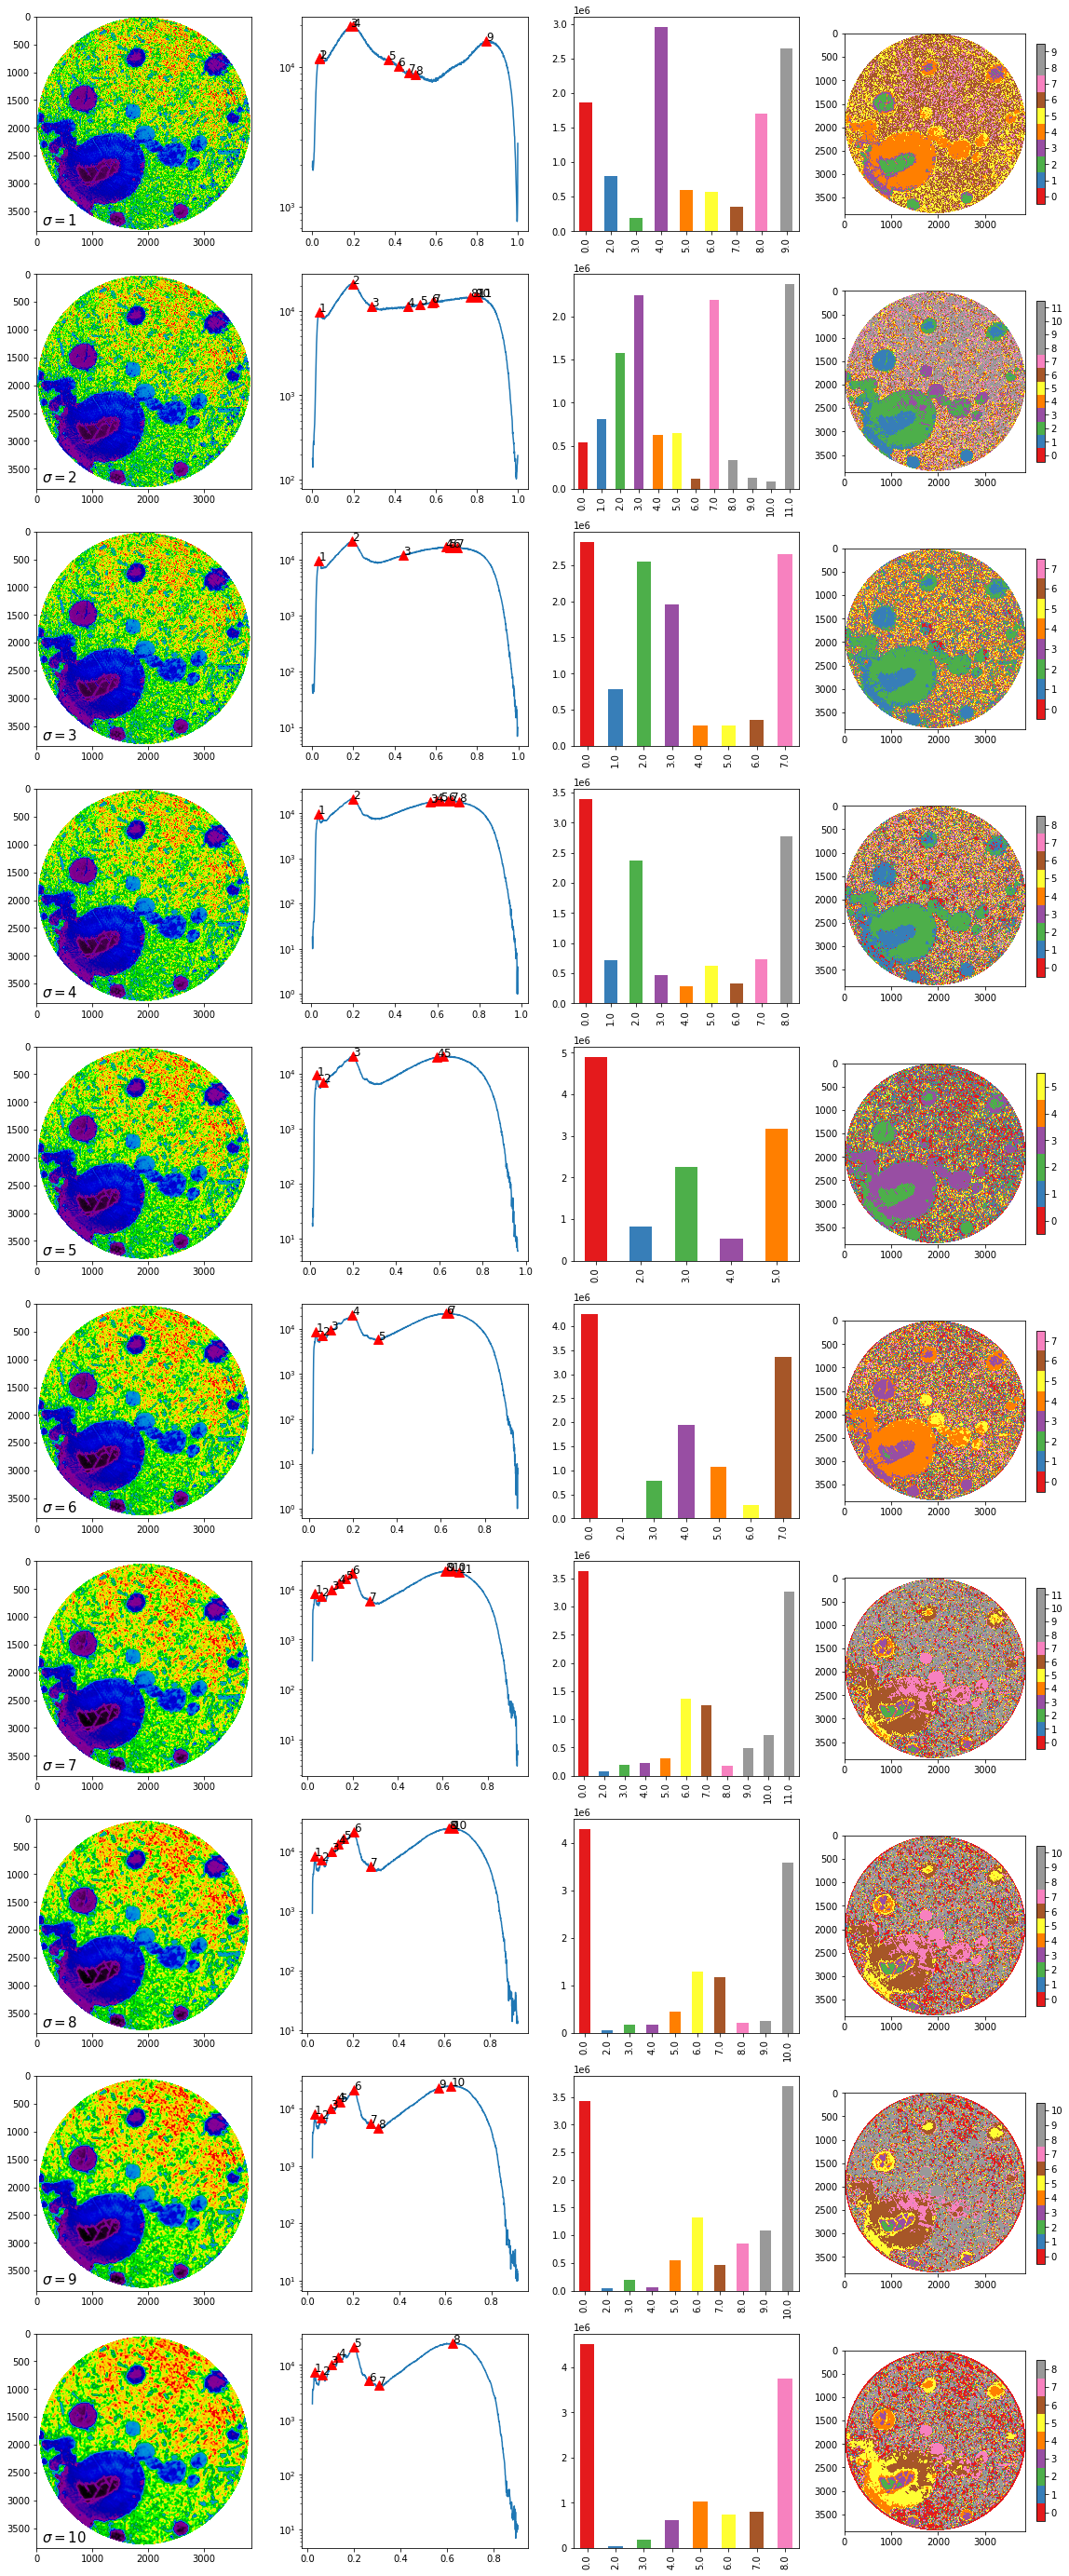

In [11]:
fig, ax = plt.subplots(len(gauss_sigmas), 4, figsize=(20, 5*len(gauss_sigmas)))

s = 1
for a, b in zip(ax[:,0], blurs):
    a.imshow(b, cmap='nipy_spectral')
    a.text(s=r'$\sigma=$'+str(s), x=100, y=3750, fontsize=15)
    s+=1
    
for a, p in zip(ax[:,1], peaks_etc):
    x = p['edges'][:-1]
    a.plot(x, p['hist'])
    a.plot(x[p['peaks']], p['hist'][p['peaks']], marker='^', markersize=10, linewidth=0, color='red')
    
    n = 1
    for x, y in zip(x[p['peaks']], p['hist'][p['peaks']]):
        a.text(s=str(n), x=x, y=y, fontsize=12)
        n += 1
    a.set_yscale('log')
    
for a, a2, p, p2 in zip(ax[:,2], ax[:,3], peak_labled, peaks_etc):
    n = len(p2['peaks'])
    bounds = np.arange(0, n+1, 1)
    print(bounds)

    cmap = mpl.colors.LinearSegmentedColormap.from_list('dfg', plt.cm.Set1(bounds), len(bounds))
#     norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
#     norm = mpl.colors.BoundaryNorm(np.arange(0, len(bounds)+1, 1), cmap.N)
    
    bins = p.flatten()
    bincnt = pd.value_counts(bins).sort_index()
    print(bincnt)
    bincnt.plot.bar(ax=a, color=[cmap(b/bounds.max()) for b in bounds])
    
#     cbar = a2.imshow(p, cmap=cmap)
#     cbar = a2.imshow(p, cmap=cmap, norm=norm)
    cbar = a2.imshow(p, cmap=cmap, vmin=0, vmax=bounds.max())
    
    step = (bounds[-1]/bounds.shape[0])/2
    ticks = [(b*bounds.max()/bounds.shape[0])+step for b in bounds]
    
    cbar = fig.colorbar(cbar, ax=a2, shrink=0.75, ticks=ticks)
    cbar.ax.set_yticklabels(bounds)
    
# fig.tight_layout()
# fig.savefig('boom.png', dpi=500, bbox_inches='tight')

In [12]:
# bounds

# [b*bounds.max()/bounds.shape[0] for b in bounds]

In [13]:
# (bounds[-1]/bounds.shape[0])/2

In [14]:
# plt.imshow(p)
# plt.colorbar()

In [15]:
# cmap(1000)

In [16]:
# plt.cm.Set1(np.arange(0, 3))

In [17]:
plt.cm.Set1([1, 2, 3])

array([[0.21568627, 0.49411765, 0.72156863, 1.        ],
       [0.30196078, 0.68627451, 0.29019608, 1.        ],
       [0.59607843, 0.30588235, 0.63921569, 1.        ]])

In [18]:
# bounds = [0, 1, 2]

# # cmap = mpl.colors.LinearSegmentedColormap.from_list('dfg', plt.cm.Set1([0, 1, 2]), 3)
# # cmap = mpl.colors.LinearSegmentedColormap.from_list('dfg', plt.cm.Set1(bounds), 3)
# cmap = mpl.colors.LinearSegmentedColormap.from_list('dfg', plt.cm.Set1(bounds), len(bounds))
# fig, ax = plt.subplots(figsize=(20, 20))
# cbar = ax.imshow(peak_labled[0], cmap=cmap)
# fig.colorbar(cbar, ticks=[2/6, 1, 10/6])

In [19]:
# plt.imshow(peak_labled[0], cmap='seismic')
# plt.colorbar()

In [20]:
# np.arange(0, 2, 1)

In [21]:
# ticks

In [22]:
# test = peak_labled[0].flatten()
# np.bincount(test[~np.isnan(test)].astype(int))

# import pandas as pd
# pd.value_counts(test)

In [23]:
# cbar.axes.set

In [24]:
# cbar.set_clim()

In [25]:
# def label_by_peaks(img, peaks):
#     zeros = np.zeros_like(img)
#     std = peaks['stds']
#     for n, m in enumerate(peaks['means']):
#         plower = m - std
#         pupper = m + std
#         print(m, std)
#         print(plower, pupper)
#         x, y = np.where(np.logical_and(img>plower, img<pupper))
#         zeros[x, y] = n + 1
        
#     return helpers.remove_data_based_on_radius(zeros, mask_value=np.nan)

# plt.imshow(label_by_peaks(blurs[0], peaks_etc[0]), cmap='cool')
# peaks_etc[0]['means']

In [26]:
# x, y = np.where(np.logical_and(blurs[0]>=23000, blurs[0]<=25000))
# zeros = np.zeros_like(blurs[0])
# zeros[x, y] = 1
# plt.imshow(zeros, cmap='cool')

In [27]:
# peaks_etc[0]

In [28]:
# h, e = np.histogram(imarr_blur[~np.isnan(imarr_blur)].flatten(), bins=1000)

In [29]:
# peaks, other = find_peaks(h, height=1e3, width=4)

In [30]:
# means = e[peaks]
# stds = np.std(imarr_blur[~np.isnan(imarr_blur)].flatten())/3
# stds

In [31]:
# fig, ax = plt.subplots(figsize=(10, 6))

# # x = np.log10(e[:-1])
# x = e[:-1]

# ax.plot(x, h)
# ax.set_yscale('log')
# ax.set_xlabel('log(CT value)', fontsize=15)
# # ax.set_ylim(1e1, 1e8)

# ax.plot(x[peaks], h[peaks], marker='^', markersize=10, linewidth=0, color='red')

# ax.fill_between([means[0]-stds, means[0]+stds], 1e0, 5e5, color='darkorange', alpha=0.5)

# ax.fill_between([means[1]-stds, means[1]+stds], 1e0, 5e5, color='green', alpha=0.5)

# ax.text(s='peak 1', x=means[0]-1000, y=1e1)
# ax.text(s='peak 2', x=means[1]-1000, y=1e1)

In [32]:
# # TODO : why does this work when its imarr and imarr_blur
# #        but doesn't work when using all the same array?

# peak1mask = (imarr < means[0]+stds) & (imarr_blur > means[0]-stds).astype(int)

# peak2mask = (imarr < means[1]+stds) & (imarr_blur > means[1]-stds).astype(int)

In [33]:
# # returns indices where peak1mask is 1
# x1, y1 = peak1mask.nonzero()

# zeros = np.zeros_like(imarr)
# zeros[x1, y1] = 1
# zeros[x1, y1] = 0


# x2, y2 = peak2mask.nonzero()
# zeros[x2, y2] = 2

# print(zeros.max())

# fig, ax = plt.subplots(figsize=(15, 15))

# imlabeled = helpers.remove_data_based_on_radius(zeros, mask_value=np.nan)


# # cbar = ax.imshow(imlabeled, cmap='plasma')
# cbar = ax.imshow(imlabeled, cmap='cool')

# fig.colorbar(cbar)

# """
# At this point it seems like I can label the vesicles
# which appear as 0 valued here.

# I just need to connect the dots that are the same.
# """

In [34]:
# np.unique(zeros)